In [1]:
! pip -q install segmentation_models_pytorch

In [2]:
import os
import json
import warnings


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed_everything()


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Create CariesDataset

In [5]:
class CariesDataset(Dataset):
    def __init__(self, images_path_list, labels_path_list, augmentation = True, device = 'cpu', image_size = (384, 768)):
        self.images = images_path_list
        self.labels = labels_path_list
        self.augmentation = augmentation
        self.device = device

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])
        
        if self.augmentation:
            self.same_augmentation = transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.RandomHorizontalFlip(p = 0.5)
            ])

            self.different_augmentation = transforms.Compose([
                transforms.RandomAdjustSharpness(2),
                transforms.ColorJitter(brightness=0.5, contrast=0.5)
            ])

        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = Image.open(self.labels[idx])
        
        if self.augmentation:
            seed = np.random.randint(0, 10000)
            
            torch.random.manual_seed(seed)
            image = self.same_augmentation(image)
            image = self.different_augmentation(image)
            
            torch.random.manual_seed(seed)
            label = self.same_augmentation(label)
            
        image = self.transform(image).to(self.device)
        label = self.transform(label).to(self.device)
        
        label = 1. * (label != 0)
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [6]:
image_path = '/kaggle/input/panoramic-dental-dataset/images_cut/'
labels_path = '/kaggle/input/panoramic-dental-dataset/labels_cut/'

file_names = [filename for filename in os.listdir(image_path)]
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)


train_image_path = [image_path + file_name for file_name in train_files]
train_mask_path = [labels_path + file_name for file_name in train_files]

eval_image_path = [image_path + file_name for file_name in val_files]
eval_mask_path = [labels_path + file_name for file_name in val_files]

In [7]:
train_dataset = CariesDataset(
    images_path_list = train_image_path,
    labels_path_list = train_mask_path,
    augmentation = True,
    device = device,
)

eval_dataset = CariesDataset(
    images_path_list = eval_image_path,
    labels_path_list = eval_mask_path,
    augmentation = False,
    device = device,
)

toPIL = transforms.ToPILImage()

batch_size = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=1)

### Create LossFunction and CalculateMetricFunction

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1, activation = None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.activation = activation

    def forward(self, inputs, targets):
        if self.activation:
            inputs = self.activation(inputs)       

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice
    

    
def metric_calculate(prediction: np.ndarray, target: np.ndarray):

    target = np.uint8(target.flatten() > 0.5)
    prediction = np.uint8(prediction.flatten() > 0.5)
    TP = (prediction * target).sum()
    FN = ((1 - prediction) * target).sum()
    TN = ((1 - prediction) * (1 - target)).sum()
    FP = (prediction * (1 - target)).sum()

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-4)
    iou = TP / (TP + FP + FN + 1e-4)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-4)
    pre = TP / (TP + FP + 1e-4)
    spe = TN / (FP + TN + 1e-4)
    sen = TP / (TP + FN + 1e-4)
    
    return acc, iou, dice, pre, spe, sen

### Create model for semantic segmentation from SMP library

In [10]:
model = smp.UnetPlusPlus(
    encoder_name = 'efficientnet-b0',        
    encoder_weights = 'imagenet',     
    in_channels = 1,                  
    classes = 1,
).to(device)

model_name = 'UNetEfficientnetB0'

criterion = DiceLoss(activation=F.sigmoid)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

num_epoch = 75

### Training Process

In [11]:
print (f'Training {model_name} start.')

IoU_max = 0.
losses_train, losses_val = [], []
metrics = []

for epoch in tqdm(range(num_epoch)):
    current_train_loss, current_val_loss = 0., 0.
    current_metric = np.zeros(6)

    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        current_train_loss += loss.item() / len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in eval_dataloader:
            logits = model(images)
            loss = criterion(logits, labels)

            current_val_loss += loss.item() / len(eval_dataloader)
            current_metric += np.array(metric_calculate(
                logits.cpu().detach().numpy(), 
                labels.cpu().detach().numpy())) / len(eval_dataloader)

    losses_train.append(current_train_loss)
    losses_val.append(current_val_loss)
    metrics.append(current_metric.tolist())

    if IoU_max < metrics[-1][1]:
        torch.save(model, f'{model_name}-best.pth')
        IoU_max = metrics[-1][1]

    print (f'Epoch: {epoch + 1}, train_loss: {losses_train[-1]:.4f}, val_loss: {losses_val[-1]:.4f}, IoU: {metrics[-1][1]:.4f}')


log = {}
log['train_loss'] = losses_train 
log['eval_loss'] = losses_val
log['metric'] = metrics
log['best_score'] = IoU_max

torch.save(model, f'{model_name}-last.pth')

with open(f'log.txt', 'w') as outfile:
    json.dump(log, outfile) 

torch.cuda.empty_cache()

print ('- - ' * 30)
print (f'Training {model_name} done. Best IoU: {IoU_max:.4f}.')
print ('- - ' * 30)

Training UNetEfficientnetB0 start.


  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.9798, val_loss: 0.9809, IoU: 0.0562
Epoch: 2, train_loss: 0.9601, val_loss: 0.9758, IoU: 0.1345
Epoch: 3, train_loss: 0.9381, val_loss: 0.9524, IoU: 0.1221
Epoch: 4, train_loss: 0.8874, val_loss: 0.9322, IoU: 0.1105
Epoch: 5, train_loss: 0.8073, val_loss: 0.9718, IoU: 0.0496
Epoch: 6, train_loss: 0.6930, val_loss: 0.9475, IoU: 0.0830
Epoch: 7, train_loss: 0.5592, val_loss: 0.8635, IoU: 0.1334
Epoch: 8, train_loss: 0.4655, val_loss: 0.8531, IoU: 0.1045
Epoch: 9, train_loss: 0.4348, val_loss: 0.7881, IoU: 0.1491
Epoch: 10, train_loss: 0.3994, val_loss: 0.6935, IoU: 0.2128
Epoch: 11, train_loss: 0.3442, val_loss: 0.6523, IoU: 0.2355
Epoch: 12, train_loss: 0.3397, val_loss: 0.6514, IoU: 0.2356
Epoch: 13, train_loss: 0.3401, val_loss: 0.5800, IoU: 0.2934
Epoch: 14, train_loss: 0.3179, val_loss: 0.5812, IoU: 0.2904
Epoch: 15, train_loss: 0.2933, val_loss: 0.5713, IoU: 0.3034
Epoch: 16, train_loss: 0.3125, val_loss: 0.6014, IoU: 0.2667
Epoch: 17, train_loss: 0.3056, va

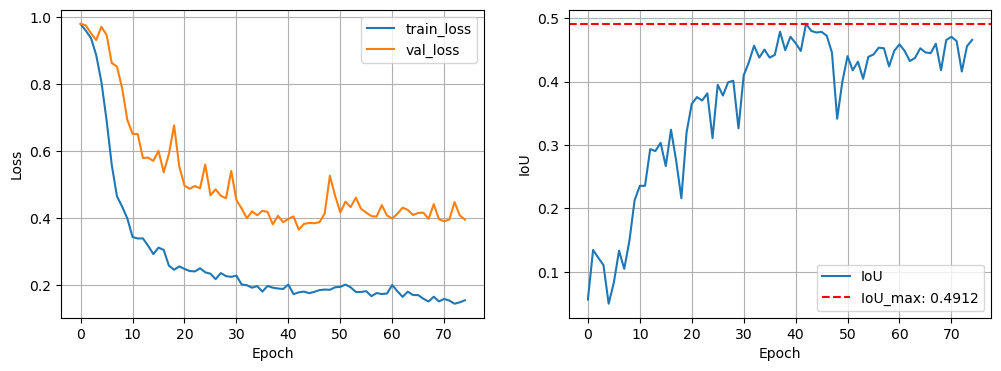

In [12]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([metric[1] for metric in metrics], label = 'IoU')
plt.axhline (IoU_max, linestyle = '--', color = 'red', label = f'IoU_max: {IoU_max:.4f}')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.savefig('efficientnet-b0.png')
plt.show()

### Inference

In [15]:
model = torch.load('UNetEfficientnetB0-best.pth').eval()
image, label = eval_dataset[6]

In [13]:

model.eval()

eval_losses = 0.
eval_metrics = np.zeros(6)

with torch.no_grad():
    for images, labels in eval_dataloader:
        logits = model(images)
        loss = criterion(logits, labels)

        eval_losses += loss.item() / len(eval_dataloader)
        eval_metrics += np.array(metric_calculate(
            logits.cpu().detach().numpy(), 
            labels.cpu().detach().numpy())) / len(eval_dataloader)

print(f'Evaluation Loss: {eval_losses:.4f}')
print(f'Evaluation Metrics: Accuracy: {eval_metrics[0]:.4f}, IoU: {eval_metrics[1]:.4f}, Dice: {eval_metrics[2]:.4f}, Precision: {eval_metrics[3]:.4f}, Specificity: {eval_metrics[4]:.4f}, Sensitivity: {eval_metrics[5]:.4f}')


Evaluation Loss: 0.3960
Evaluation Metrics: Accuracy: 0.9967, IoU: 0.4658, Dice: 0.6030, Precision: 0.7489, Specificity: 0.9992, Sensitivity: 0.5419


In [16]:
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

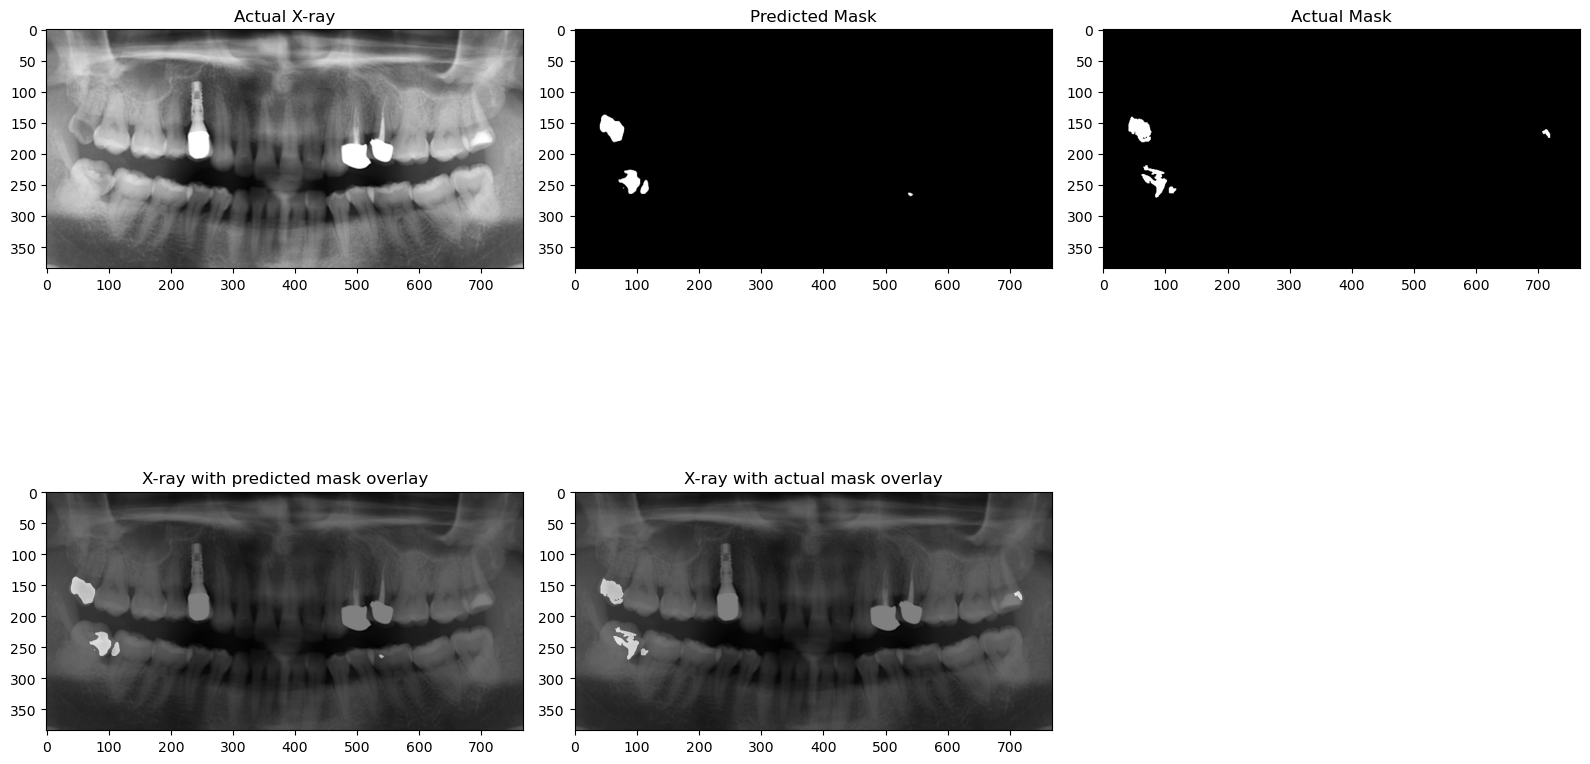

In [17]:
plt.figure(figsize=(16, 10))

# Plot actual X-ray, predicted mask, and actual mask
plt.subplot(2, 3, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Actual X-ray')

plt.subplot(2, 3, 2)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 3, 3)
plt.imshow(toPIL(label), cmap='gray')
plt.title('Actual Mask')

# Plot X-ray with predicted mask overlayed
plt.subplot(2, 3, 4)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.title('X-ray with predicted mask overlay')

# Plot X-ray with actual mask overlayed
plt.subplot(2, 3, 5)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('X-ray with actual mask overlay')

plt.tight_layout()
plt.show()


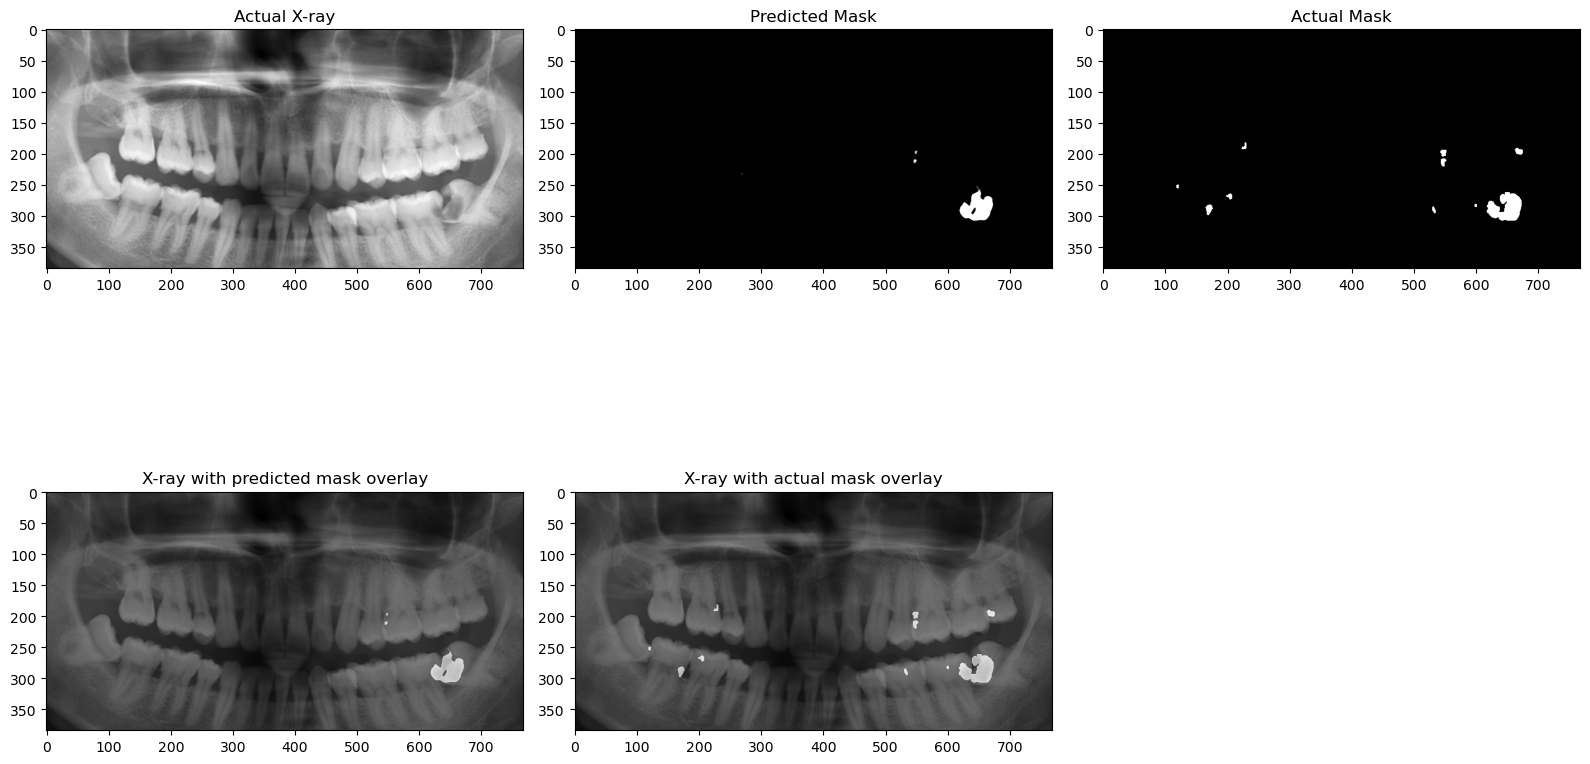

In [18]:
image, label = eval_dataset[5]
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

plt.figure(figsize=(16, 10))

# Plot actual X-ray, predicted mask, and actual mask
plt.subplot(2, 3, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Actual X-ray')

plt.subplot(2, 3, 2)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 3, 3)
plt.imshow(toPIL(label), cmap='gray')
plt.title('Actual Mask')

# Plot X-ray with predicted mask overlayed
plt.subplot(2, 3, 4)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.title('X-ray with predicted mask overlay')

# Plot X-ray with actual mask overlayed
plt.subplot(2, 3, 5)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('X-ray with actual mask overlay')

plt.tight_layout()
plt.show()



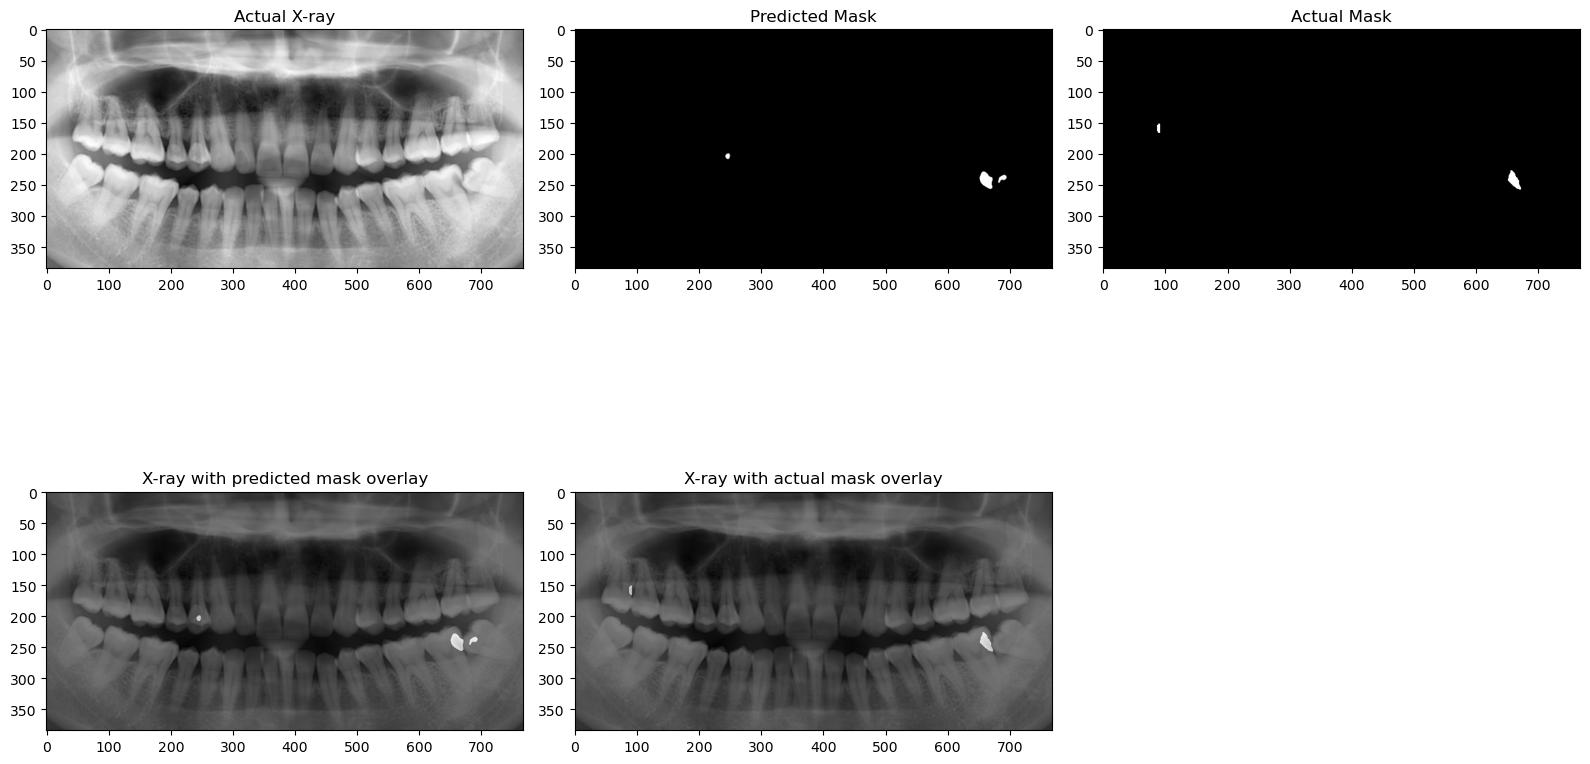

In [19]:
image, label = eval_dataset[17]
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

plt.figure(figsize=(16, 10))

# Plot actual X-ray, predicted mask, and actual mask
plt.subplot(2, 3, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Actual X-ray')

plt.subplot(2, 3, 2)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 3, 3)
plt.imshow(toPIL(label), cmap='gray')
plt.title('Actual Mask')

# Plot X-ray with predicted mask overlayed
plt.subplot(2, 3, 4)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.title('X-ray with predicted mask overlay')

# Plot X-ray with actual mask overlayed
plt.subplot(2, 3, 5)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('X-ray with actual mask overlay')

plt.tight_layout()
plt.show()



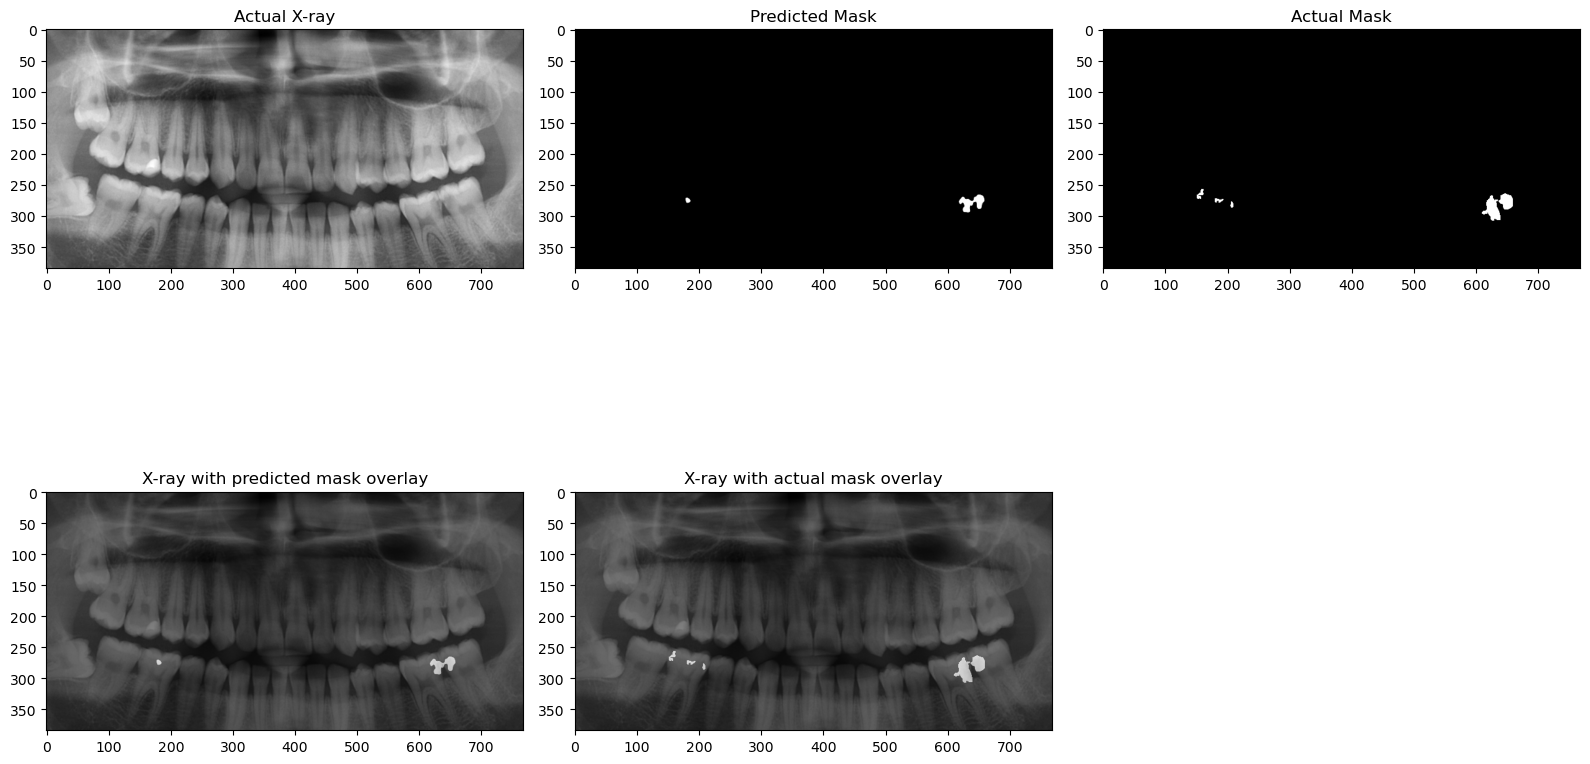

In [20]:
image, label = eval_dataset[12]
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

plt.figure(figsize=(16, 10))

# Plot actual X-ray, predicted mask, and actual mask
plt.subplot(2, 3, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Actual X-ray')

plt.subplot(2, 3, 2)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 3, 3)
plt.imshow(toPIL(label), cmap='gray')
plt.title('Actual Mask')

# Plot X-ray with predicted mask overlayed
plt.subplot(2, 3, 4)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.title('X-ray with predicted mask overlay')

# Plot X-ray with actual mask overlayed
plt.subplot(2, 3, 5)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('X-ray with actual mask overlay')

plt.tight_layout()
plt.show()



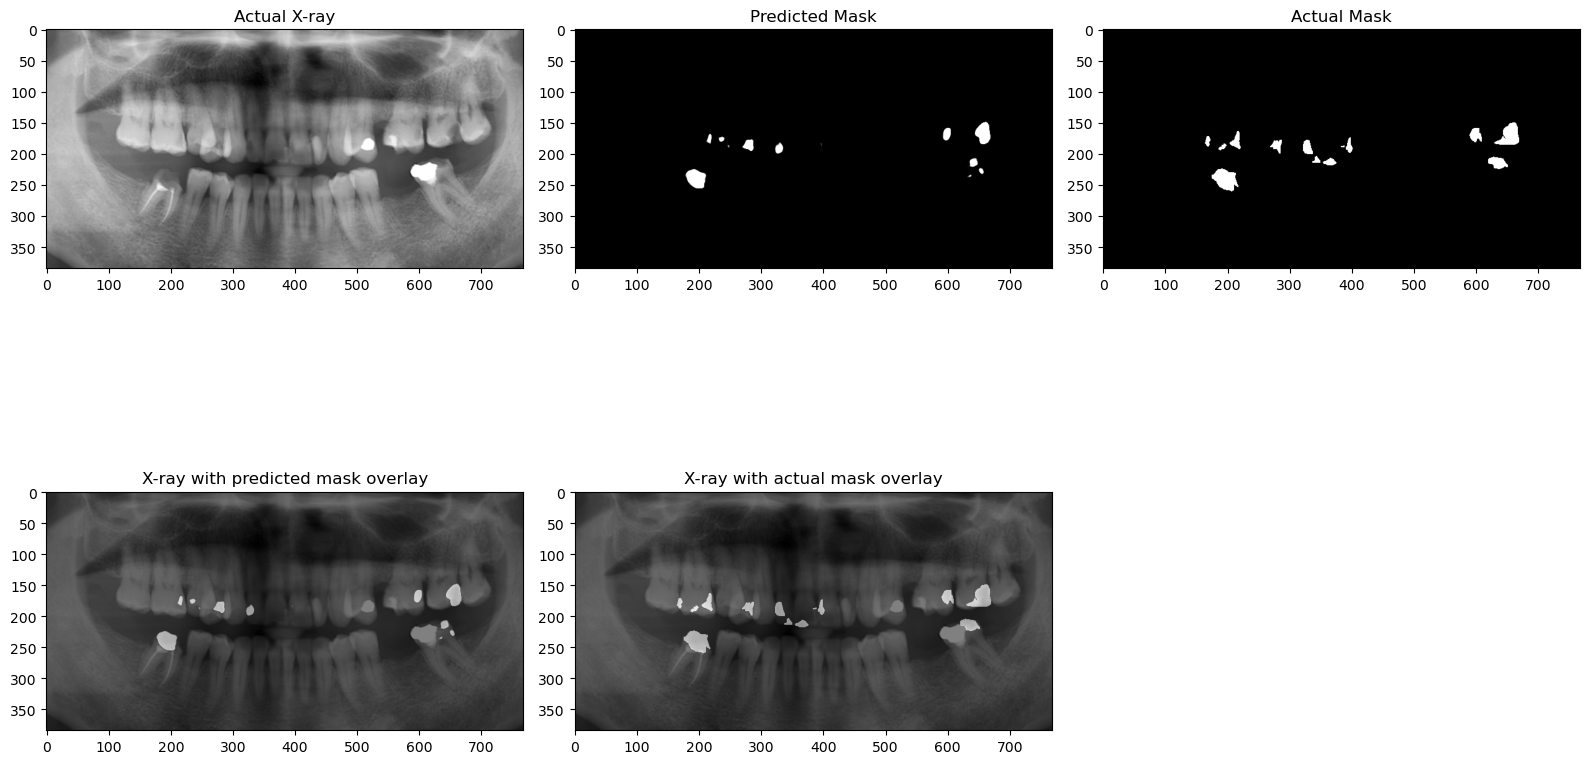

In [21]:
image, label = eval_dataset[4]
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

plt.figure(figsize=(16, 10))

# Plot actual X-ray, predicted mask, and actual mask
plt.subplot(2, 3, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Actual X-ray')

plt.subplot(2, 3, 2)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 3, 3)
plt.imshow(toPIL(label), cmap='gray')
plt.title('Actual Mask')

# Plot X-ray with predicted mask overlayed
plt.subplot(2, 3, 4)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.title('X-ray with predicted mask overlay')

# Plot X-ray with actual mask overlayed
plt.subplot(2, 3, 5)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('X-ray with actual mask overlay')

plt.tight_layout()
plt.show()



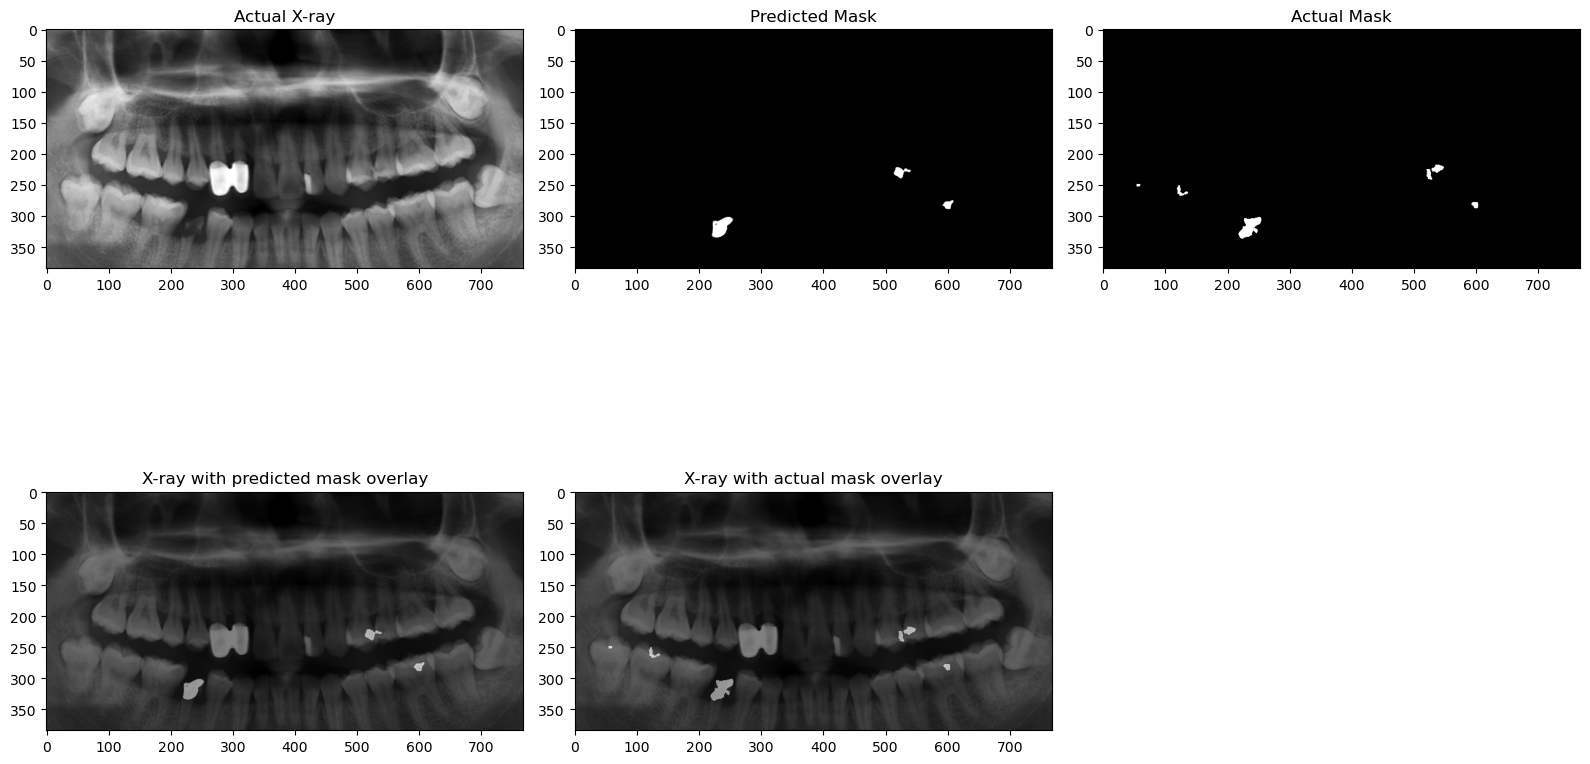

In [22]:
image, label = eval_dataset[8]
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

plt.figure(figsize=(16, 10))

# Plot actual X-ray, predicted mask, and actual mask
plt.subplot(2, 3, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Actual X-ray')

plt.subplot(2, 3, 2)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Predicted Mask')

plt.subplot(2, 3, 3)
plt.imshow(toPIL(label), cmap='gray')
plt.title('Actual Mask')

# Plot X-ray with predicted mask overlayed
plt.subplot(2, 3, 4)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(probabilities), alpha=0.5, cmap='gray')
plt.title('X-ray with predicted mask overlay')

# Plot X-ray with actual mask overlayed
plt.subplot(2, 3, 5)
plt.imshow(toPIL(image), cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('X-ray with actual mask overlay')

plt.tight_layout()
plt.show()



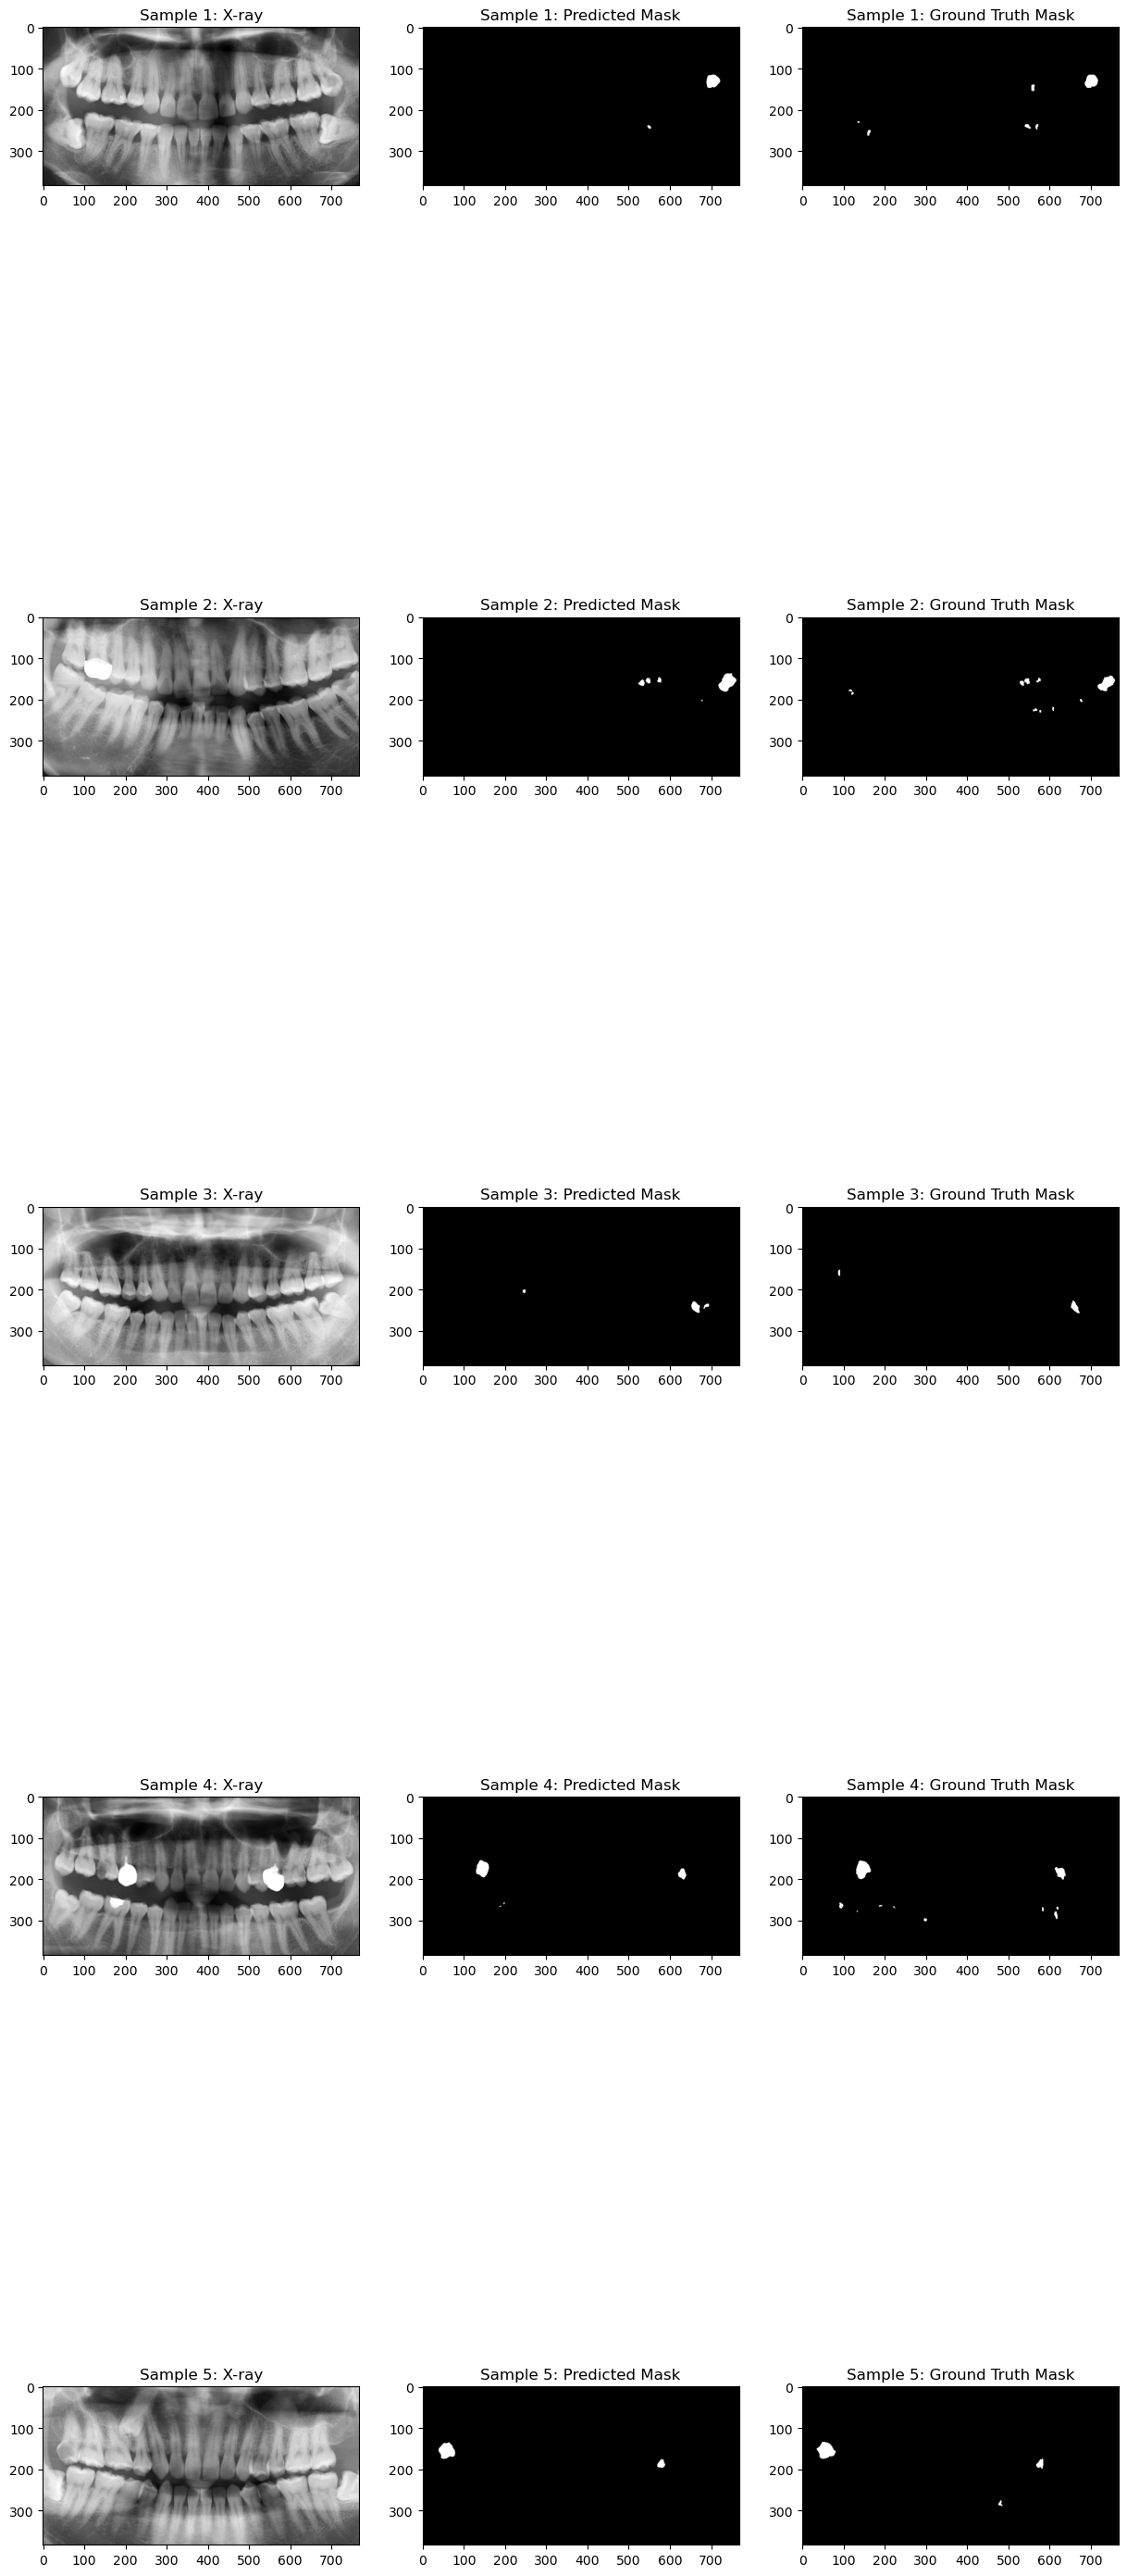

In [23]:
import random

# Select a few random samples from the evaluation dataset
sample_indices = random.sample(range(len(eval_dataset)), 5)

plt.figure(figsize=(15, 8 * len(sample_indices)))

for i, sample_idx in enumerate(sample_indices):
    image, label = eval_dataset[sample_idx]
    logits = model(image.unsqueeze(0).to(device))
    predicted_mask = torch.sigmoid(logits[0]).cpu().detach().numpy()

    plt.subplot(len(sample_indices), 3, i * 3 + 1)
    plt.imshow(toPIL(image), cmap='gray')
    plt.title(f'Sample {i + 1}: X-ray')

    plt.subplot(len(sample_indices), 3, i * 3 + 2)
    plt.imshow(predicted_mask[0], cmap='gray')
    plt.title(f'Sample {i + 1}: Predicted Mask')

    plt.subplot(len(sample_indices), 3, i * 3 + 3)
    plt.imshow(toPIL(label), cmap='gray')
    plt.title(f'Sample {i + 1}: Ground Truth Mask')

plt.show()


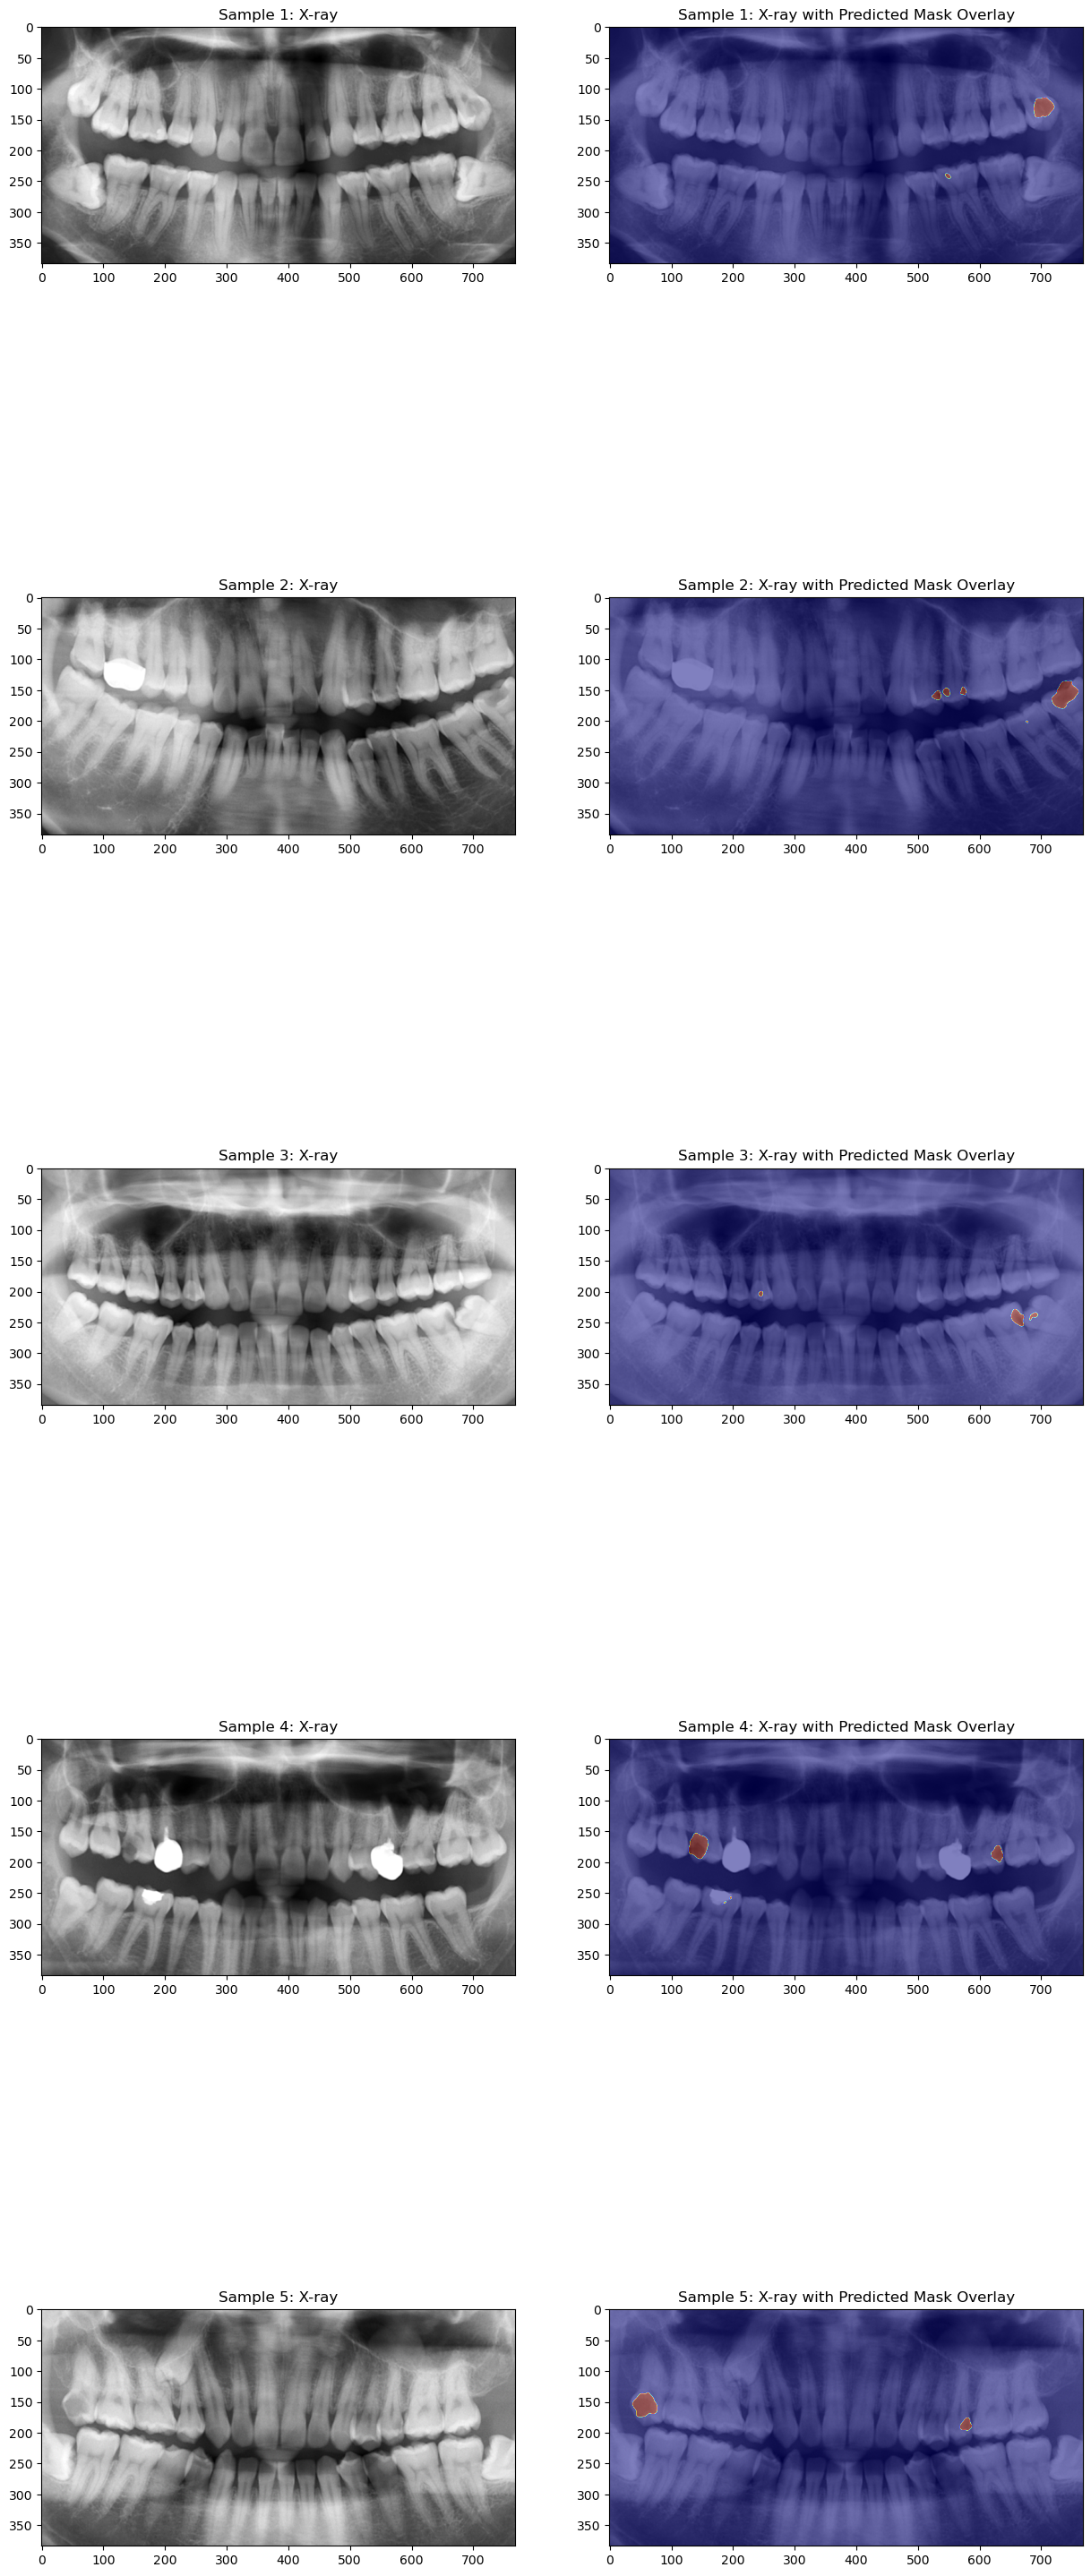

In [24]:
plt.figure(figsize=(15, 8 * len(sample_indices)))

for i, sample_idx in enumerate(sample_indices):
    image, label = eval_dataset[sample_idx]
    logits = model(image.unsqueeze(0).to(device))
    predicted_mask = torch.sigmoid(logits[0]).cpu().detach().numpy()

    plt.subplot(len(sample_indices), 2, i * 2 + 1)
    plt.imshow(toPIL(image), cmap='gray')
    plt.title(f'Sample {i + 1}: X-ray')

    plt.subplot(len(sample_indices), 2, i * 2 + 2)
    plt.imshow(toPIL(image), cmap='gray')
    plt.imshow(predicted_mask[0], alpha=0.5, cmap='jet')
    plt.title(f'Sample {i + 1}: X-ray with Predicted Mask Overlay')

plt.show()


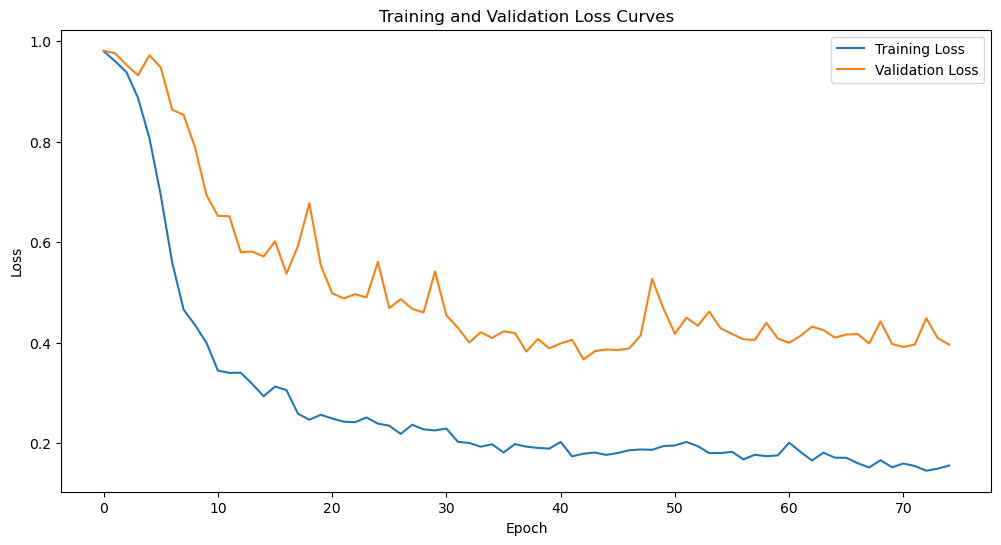

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()


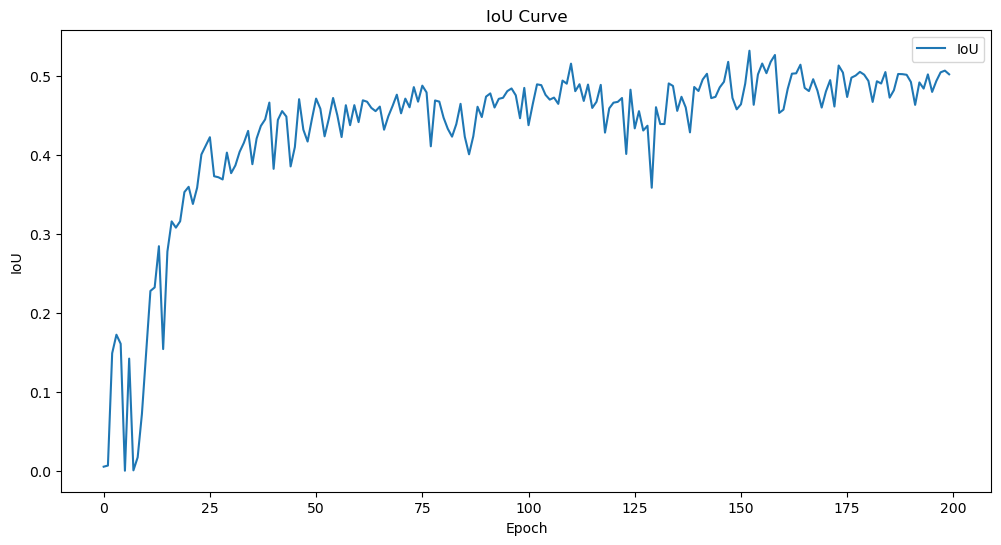

In [40]:
plt.figure(figsize=(12, 6))

plt.plot([metric[1] for metric in metrics], label='IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('IoU Curve')
plt.show()
